In [6]:
import os
import random 
import datetime
import numpy as np
import pandas as pd
from sklearn import tree
from datetime import timedelta
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
import pickle

In [7]:
objects = []
with (open("Dict_CatBoostClassifier_with_Explanation_22_2_2021_01_F", "rb")) as openfile:
    while True:
        try:
            objects.append(pickle.load(openfile))
        except EOFError:
            break

In [8]:
Output = objects[0]

In [9]:
Output.keys()

dict_keys(['Overall_Training_Accuracy', 'Overall_Training_Precision', 'Overall_Training_Recall', 'Overall_Testing_Accuracy', 'Overall_Testing_Precision', 'Overall_Testing_Recall', 'Top_K_Accuracy', 'Top_K_Precision', 'Top_K_Recall', 'Data_size_Testing', 'Ones_Testing', 'TP_Testing', 'Explainer_df_Top_K', 'Explainer_df_Mid_K', 'Explainer_df_Bottom_K', 'Testing_data', 'Classifier', 'Model_variables', 'Time_points'])

c:\users\redline pc\appdata\local\programs\python\python38\lib\site-packages\numpy\lib\function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
c:\users\redline pc\appdata\local\programs\python\python38\lib\site-packages\numpy\lib\function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
c:\users\redline pc\appdata\local\programs\python\python38\lib\site-packages\numpy\lib\function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
c:\users\redline pc\appdata\local\programs\python\python38\lib\site-packages\numpy\lib\function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
c:\users\redline pc\appdata\local\programs\python\python38\lib\site-packages\numpy\lib\function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
c:\users\redline pc\appdata\local\programs\python\

c:\users\redline pc\appdata\local\programs\python\python38\lib\site-packages\numpy\lib\function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
c:\users\redline pc\appdata\local\programs\python\python38\lib\site-packages\numpy\lib\function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
c:\users\redline pc\appdata\local\programs\python\python38\lib\site-packages\numpy\lib\function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
c:\users\redline pc\appdata\local\programs\python\python38\lib\site-packages\numpy\lib\function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
c:\users\redline pc\appdata\local\programs\python\python38\lib\site-packages\numpy\lib\function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
c:\users\redline pc\appdata\local\programs\python\

c:\users\redline pc\appdata\local\programs\python\python38\lib\site-packages\numpy\lib\function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
c:\users\redline pc\appdata\local\programs\python\python38\lib\site-packages\numpy\lib\function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
c:\users\redline pc\appdata\local\programs\python\python38\lib\site-packages\numpy\lib\function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
c:\users\redline pc\appdata\local\programs\python\python38\lib\site-packages\numpy\lib\function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
c:\users\redline pc\appdata\local\programs\python\python38\lib\site-packages\numpy\lib\function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
c:\users\redline pc\appdata\local\programs\python\

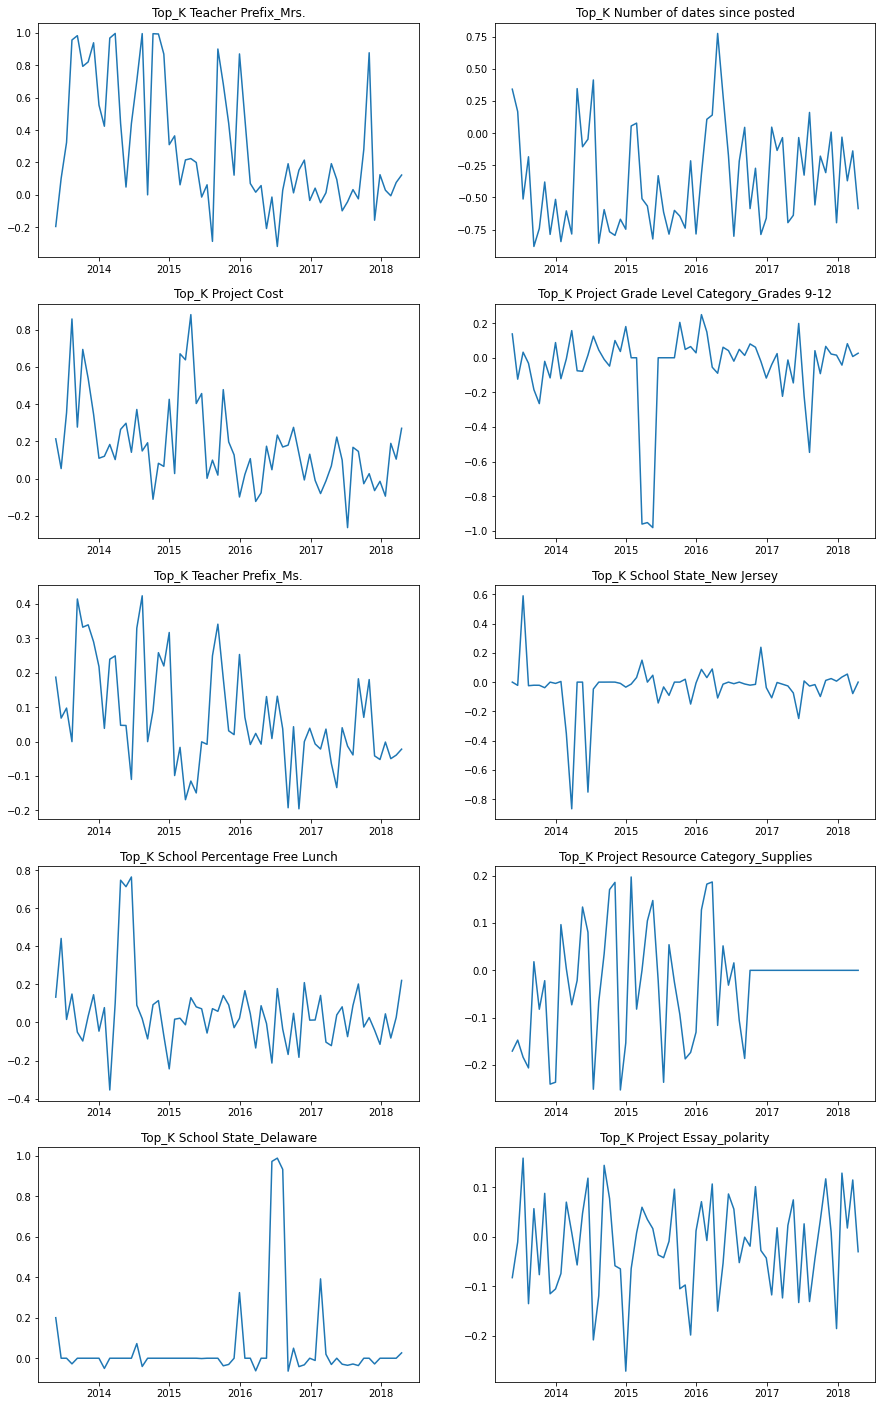

In [10]:
K=100
dict_top = dict()
top_ats=15
count=0
cols=[]
dates=[]
for date_index in range (3,len(Output['Time_points']),4):
#     print("===============================",Output['Time_points'][date_index],"=================================")
    As_of_top_K = Output["Explainer_df_Top_K"][date_index].apply(pd.to_numeric, errors='ignore')
    As_of_top_K_np = As_of_top_K.to_numpy()
    As_of_top_K_np[As_of_top_K_np < 0] = 0
    As_of_top_K_pos_df = pd.DataFrame(data=As_of_top_K_np, columns=As_of_top_K.columns)  # 1st row as the column names
    
    As_of_top_K_pos_df=As_of_top_K_pos_df.T
    Normalized_As_of_top_K_pos_df=(As_of_top_K_pos_df-As_of_top_K_pos_df.mean())/(As_of_top_K_pos_df.max()-As_of_top_K_pos_df.min())
#     Normalized_As_of_top_K_pos_df=(As_of_top_K_pos_df-As_of_top_K_pos_df.mean())/As_of_top_K_pos_df.std()
    Normalized_As_of_top_K_pos_df=Normalized_As_of_top_K_pos_df.T
    
    important_columns_df = Normalized_As_of_top_K_pos_df.dropna(axis=1, how='all')
    
    Original_data = Output["Testing_data"][count]
    dates+=[Output['Time_points'][date_index]]
    dict_top[Output['Time_points'][date_index]]=dict()
    for col_name in important_columns_df.columns:
        if col_name not in cols: cols+=[col_name]
        co = np.corrcoef(Original_data[col_name].iloc[:100],important_columns_df[col_name])[0,1]
        if pd.notna(co):
            dict_top[Output['Time_points'][date_index]][col_name]=co
    count+=1

df_Top = pd.DataFrame(columns=dates)
for col_name in cols:
    df_Top.loc[col_name] = 0.0
for d in dict_top:
    for c in dict_top[d]:
        df_Top.at[c, d] = dict_top[d][c]
df_Top_transposed = df_Top.T
describe_top_df = df_Top_transposed.describe().T
describe_top_df= describe_top_df.sort_values(by=['mean'], ascending=False)

fig, axs = plt.subplots(5, 2,figsize=(15,25))
        
for i in range (5):
    axs[i, 0].plot(df_Top_transposed[describe_top_df.index[i]])
    axs[i, 0].title.set_text("Top_K "+describe_top_df.index[i])

for i in range (1,6):
    axs[i-1, 1].plot(df_Top_transposed[describe_top_df.index[-i]])
    axs[i-1, 1].title.set_text("Top_K "+describe_top_df.index[-i]) 
            



c:\users\redline pc\appdata\local\programs\python\python38\lib\site-packages\numpy\lib\function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
c:\users\redline pc\appdata\local\programs\python\python38\lib\site-packages\numpy\lib\function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
c:\users\redline pc\appdata\local\programs\python\python38\lib\site-packages\numpy\lib\function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
c:\users\redline pc\appdata\local\programs\python\python38\lib\site-packages\numpy\lib\function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
c:\users\redline pc\appdata\local\programs\python\python38\lib\site-packages\numpy\lib\function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
c:\users\redline pc\appdata\local\programs\python\

c:\users\redline pc\appdata\local\programs\python\python38\lib\site-packages\numpy\lib\function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
c:\users\redline pc\appdata\local\programs\python\python38\lib\site-packages\numpy\lib\function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
c:\users\redline pc\appdata\local\programs\python\python38\lib\site-packages\numpy\lib\function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
c:\users\redline pc\appdata\local\programs\python\python38\lib\site-packages\numpy\lib\function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
c:\users\redline pc\appdata\local\programs\python\python38\lib\site-packages\numpy\lib\function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
c:\users\redline pc\appdata\local\programs\python\

c:\users\redline pc\appdata\local\programs\python\python38\lib\site-packages\numpy\lib\function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
c:\users\redline pc\appdata\local\programs\python\python38\lib\site-packages\numpy\lib\function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
c:\users\redline pc\appdata\local\programs\python\python38\lib\site-packages\numpy\lib\function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
c:\users\redline pc\appdata\local\programs\python\python38\lib\site-packages\numpy\lib\function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
c:\users\redline pc\appdata\local\programs\python\python38\lib\site-packages\numpy\lib\function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
c:\users\redline pc\appdata\local\programs\python\

,Project Cost,Number of dates since posted,School Percentage Free Lunch,Project Short Description_polarity,Project Short Description_subjectivity,Project Essay_polarity,Project Essay_subjectivity,Project Need Statement_polarity,School Metro Type_rural,School Metro Type_town,...,Project Resource Category_Instructional Technology,Project Resource Category_Lab Equipment,Project Resource Category_Musical Instruments,"Project Resource Category_Reading Nooks, Desks & Storage",Project Resource Category_Sports & Exercise Equipment,Project Resource Category_Supplies,Project Resource Category_Technology,Project Resource Category_Trips,Project Resource Category_Visitors,Project Resource Category_nan
0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.000000,-0.126409,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
96,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
97,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
98,0.0,-0.132676,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


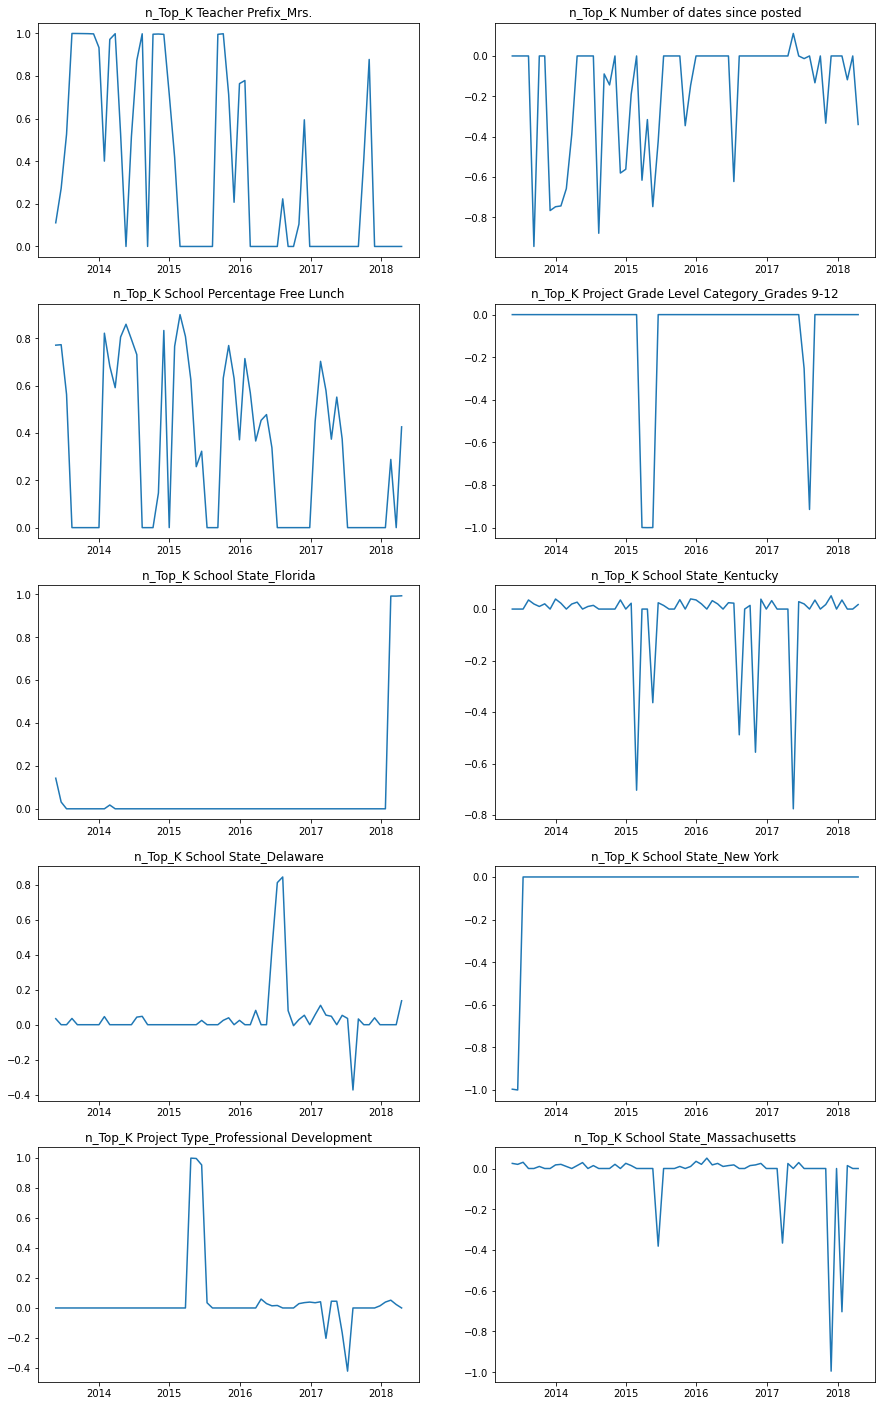

In [6]:
K=100
dict_top = dict()
top_ats=15
count=0
cols=[]
dates=[]
for date_index in range (3,len(Output['Time_points']),4):
#     print("===============================",Output['Time_points'][date_index],"=================================")
    As_of_top_K = Output["Explainer_df_Top_K"][date_index].apply(pd.to_numeric, errors='ignore')
    As_of_top_K_np = As_of_top_K.to_numpy()
    As_of_top_K_np[As_of_top_K_np > 0] = 0
    As_of_top_K_pos_df = pd.DataFrame(data=As_of_top_K_np, columns=As_of_top_K.columns)  # 1st row as the column names
    Normalized_As_of_top_K_pos_df=(As_of_top_K_pos_df-As_of_top_K_pos_df.mean())/As_of_top_K_pos_df.std()
    important_columns_df = Normalized_As_of_top_K_pos_df.dropna(axis=1, how='all')
    
    Original_data = Output["Testing_data"][count]
    dates+=[Output['Time_points'][date_index]]
    dict_top[Output['Time_points'][date_index]]=dict()
    for col_name in important_columns_df.columns:
        if col_name not in cols: cols+=[col_name]
        co = np.corrcoef(Original_data[col_name].iloc[:100],important_columns_df[col_name])[0,1]
        if pd.notna(co):
            dict_top[Output['Time_points'][date_index]][col_name]=co
    count+=1

df_Top = pd.DataFrame(columns=dates)
for col_name in cols:
    df_Top.loc[col_name] = 0.0
for d in dict_top:
    for c in dict_top[d]:
        df_Top.at[c, d] = dict_top[d][c]
df_Top_transposed = df_Top.T
describe_top_df = df_Top_transposed.describe().T
describe_top_df= describe_top_df.sort_values(by=['mean'], ascending=False)

fig, axs = plt.subplots(5, 2,figsize=(15,25))
        
for i in range (5):
    axs[i, 0].plot(df_Top_transposed[describe_top_df.index[i]])
    axs[i, 0].title.set_text("n_Top_K "+describe_top_df.index[i])

for i in range (1,6):
    axs[i-1, 1].plot(df_Top_transposed[describe_top_df.index[-i]])
    axs[i-1, 1].title.set_text("n_Top_K "+describe_top_df.index[-i]) 
            
As_of_top_K_pos_df

c:\users\redline pc\appdata\local\programs\python\python38\lib\site-packages\numpy\lib\function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
c:\users\redline pc\appdata\local\programs\python\python38\lib\site-packages\numpy\lib\function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
c:\users\redline pc\appdata\local\programs\python\python38\lib\site-packages\numpy\lib\function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
c:\users\redline pc\appdata\local\programs\python\python38\lib\site-packages\numpy\lib\function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
c:\users\redline pc\appdata\local\programs\python\python38\lib\site-packages\numpy\lib\function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
c:\users\redline pc\appdata\local\programs\python\

c:\users\redline pc\appdata\local\programs\python\python38\lib\site-packages\numpy\lib\function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
c:\users\redline pc\appdata\local\programs\python\python38\lib\site-packages\numpy\lib\function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
c:\users\redline pc\appdata\local\programs\python\python38\lib\site-packages\numpy\lib\function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
c:\users\redline pc\appdata\local\programs\python\python38\lib\site-packages\numpy\lib\function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
c:\users\redline pc\appdata\local\programs\python\python38\lib\site-packages\numpy\lib\function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
c:\users\redline pc\appdata\local\programs\python\

c:\users\redline pc\appdata\local\programs\python\python38\lib\site-packages\numpy\lib\function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
c:\users\redline pc\appdata\local\programs\python\python38\lib\site-packages\numpy\lib\function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
c:\users\redline pc\appdata\local\programs\python\python38\lib\site-packages\numpy\lib\function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
c:\users\redline pc\appdata\local\programs\python\python38\lib\site-packages\numpy\lib\function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
c:\users\redline pc\appdata\local\programs\python\python38\lib\site-packages\numpy\lib\function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
c:\users\redline pc\appdata\local\programs\python\

Teacher Prefix_Mrs.
Project Cost
School Percentage Free Lunch
Project Type_Professional Development
Project Type_Student-Led
Number of dates since posted
Project Grade Level Category_Grades 9-12
School State_Hawaii
School State_New Jersey
School State_New York


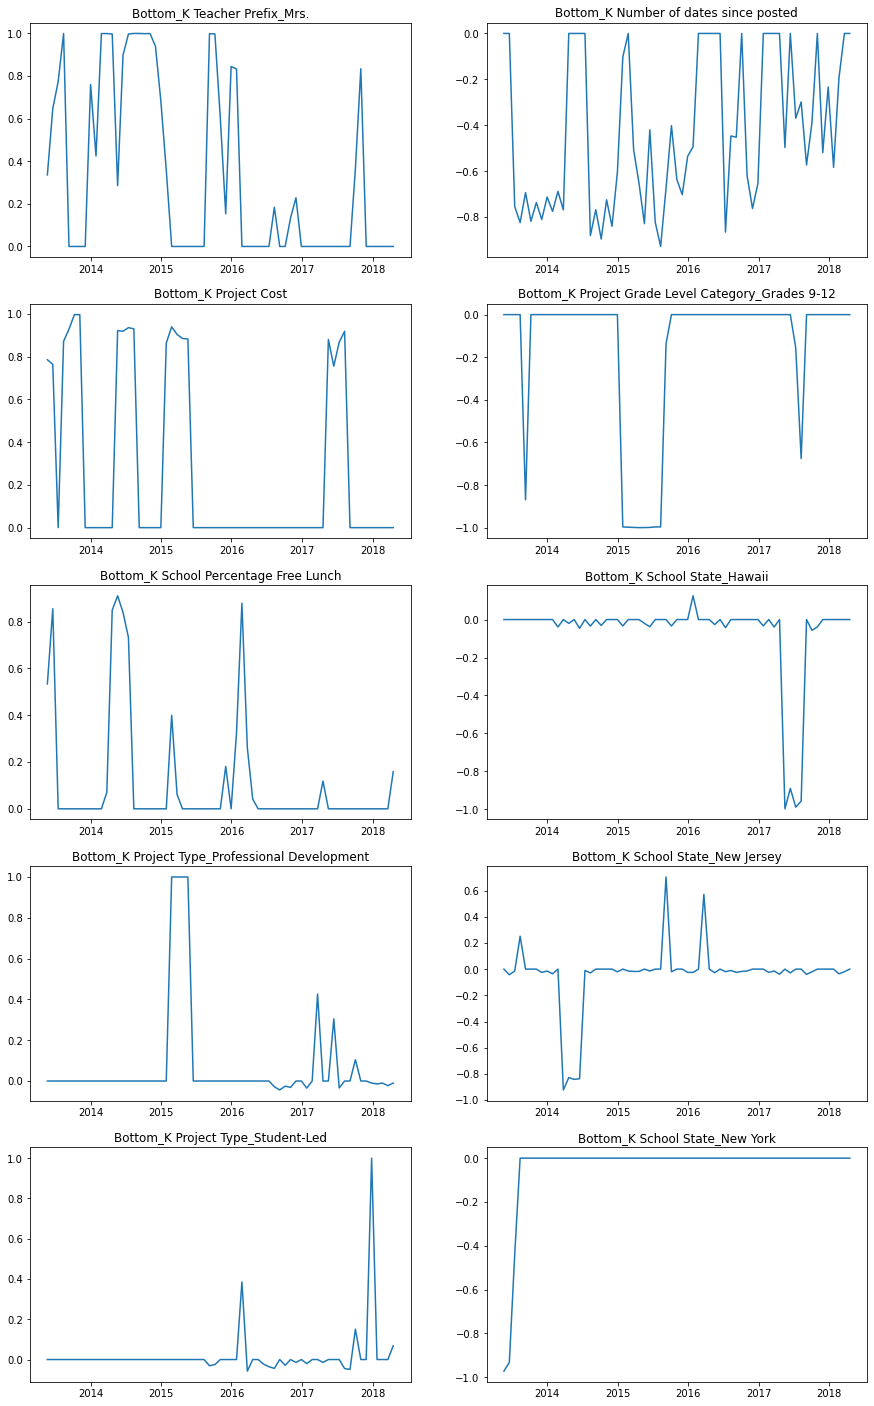

In [11]:
K=100
dict_top = dict()
top_ats=15
count=0
cols=[]
dates=[]
for date_index in range (3,len(Output['Time_points']),4):
#     print("===============================",Output['Time_points'][date_index],"=================================")
    As_of_top_K = Output["Explainer_df_Bottom_K"][date_index].apply(pd.to_numeric, errors='ignore')
    As_of_top_K_np = As_of_top_K.to_numpy()
    As_of_top_K_np[As_of_top_K_np < 0] = 0
    As_of_top_K_pos_df = pd.DataFrame(data=As_of_top_K_np, columns=As_of_top_K.columns)  # 1st row as the column names
#     Normalized_As_of_top_K_pos_df=(As_of_top_K_pos_df-As_of_top_K_pos_df.mean())/As_of_top_K_pos_df.std()
    Normalized_As_of_top_K_pos_df=(As_of_top_K_pos_df-As_of_top_K_pos_df.mean())/(As_of_top_K_pos_df.max()-As_of_top_K_pos_df.min())
    important_columns_df = Normalized_As_of_top_K_pos_df.dropna(axis=1, how='all')
    
    Original_data = Output["Testing_data"][count]
    dates+=[Output['Time_points'][date_index]]
    dict_top[Output['Time_points'][date_index]]=dict()
    for col_name in important_columns_df.columns:
        if col_name not in cols: cols+=[col_name]
        co = np.corrcoef(Original_data[col_name].iloc[len(Original_data[col_name])-100:],important_columns_df[col_name])[0,1]
        if pd.notna(co):
            dict_top[Output['Time_points'][date_index]][col_name]=co
    count+=1

df_Top = pd.DataFrame(columns=dates)
for col_name in cols:
    df_Top.loc[col_name] = 0.0
for d in dict_top:
    for c in dict_top[d]:
        df_Top.at[c, d] = dict_top[d][c]
df_Top_transposed = df_Top.T
describe_top_df = df_Top_transposed.describe().T
describe_top_df= describe_top_df.sort_values(by=['mean'], ascending=False)

fig, axs = plt.subplots(5, 2,figsize=(15,25))
        
for i in range (5):
    print(describe_top_df.index[i])
    axs[i, 0].plot(df_Top_transposed[describe_top_df.index[i]])
    axs[i, 0].title.set_text("Bottom_K "+describe_top_df.index[i])

for i in range (1,6):
    print(describe_top_df.index[-i])
    axs[i-1, 1].plot(df_Top_transposed[describe_top_df.index[-i]])
    axs[i-1, 1].title.set_text("Bottom_K "+describe_top_df.index[-i]) 
            


c:\users\redline pc\appdata\local\programs\python\python38\lib\site-packages\numpy\lib\function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
c:\users\redline pc\appdata\local\programs\python\python38\lib\site-packages\numpy\lib\function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
c:\users\redline pc\appdata\local\programs\python\python38\lib\site-packages\numpy\lib\function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
c:\users\redline pc\appdata\local\programs\python\python38\lib\site-packages\numpy\lib\function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
c:\users\redline pc\appdata\local\programs\python\python38\lib\site-packages\numpy\lib\function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
c:\users\redline pc\appdata\local\programs\python\

c:\users\redline pc\appdata\local\programs\python\python38\lib\site-packages\numpy\lib\function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
c:\users\redline pc\appdata\local\programs\python\python38\lib\site-packages\numpy\lib\function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
c:\users\redline pc\appdata\local\programs\python\python38\lib\site-packages\numpy\lib\function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
c:\users\redline pc\appdata\local\programs\python\python38\lib\site-packages\numpy\lib\function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
c:\users\redline pc\appdata\local\programs\python\python38\lib\site-packages\numpy\lib\function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
c:\users\redline pc\appdata\local\programs\python\

c:\users\redline pc\appdata\local\programs\python\python38\lib\site-packages\numpy\lib\function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
c:\users\redline pc\appdata\local\programs\python\python38\lib\site-packages\numpy\lib\function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
c:\users\redline pc\appdata\local\programs\python\python38\lib\site-packages\numpy\lib\function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
c:\users\redline pc\appdata\local\programs\python\python38\lib\site-packages\numpy\lib\function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
c:\users\redline pc\appdata\local\programs\python\python38\lib\site-packages\numpy\lib\function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
c:\users\redline pc\appdata\local\programs\python\

School Percentage Free Lunch
Teacher Prefix_Mrs.
Project Cost
Project Type_Professional Development
School State_Colorado
Number of dates since posted
Project Grade Level Category_Grades 9-12
School State_New Jersey
School State_Massachusetts
School State_Hawaii


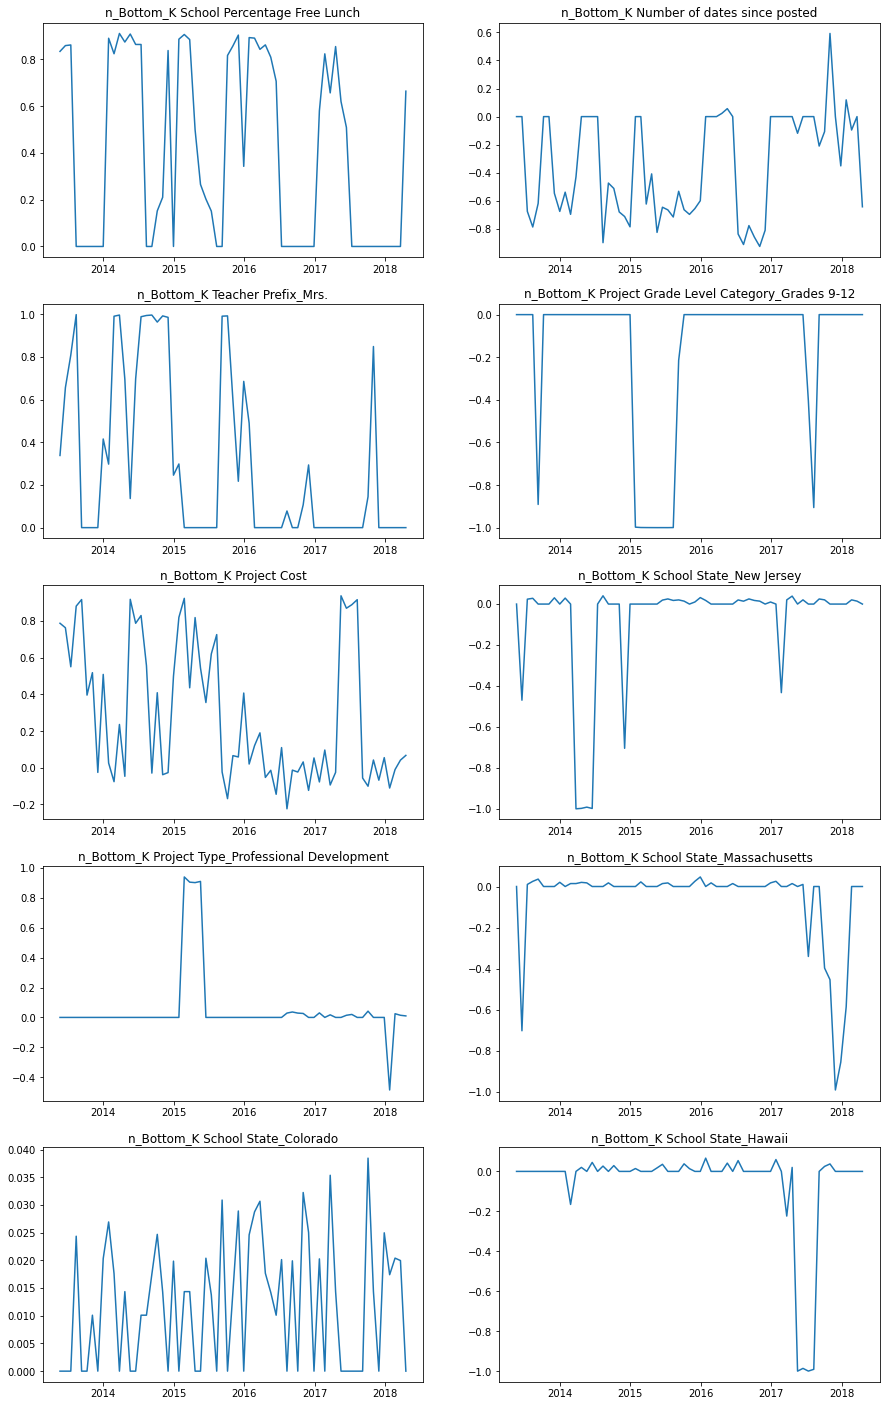

In [8]:
K=100
dict_top = dict()
top_ats=15
count=0
cols=[]
dates=[]
for date_index in range (3,len(Output['Time_points']),4):
#     print("===============================",Output['Time_points'][date_index],"=================================")
    As_of_top_K = Output["Explainer_df_Bottom_K"][date_index].apply(pd.to_numeric, errors='ignore')
    As_of_top_K_np = As_of_top_K.to_numpy()
    As_of_top_K_np[As_of_top_K_np > 0] = 0
    As_of_top_K_pos_df = pd.DataFrame(data=As_of_top_K_np, columns=As_of_top_K.columns)  # 1st row as the column names
    Normalized_As_of_top_K_pos_df=(As_of_top_K_pos_df-As_of_top_K_pos_df.mean())/As_of_top_K_pos_df.std()
    important_columns_df = Normalized_As_of_top_K_pos_df.dropna(axis=1, how='all')
    
    Original_data = Output["Testing_data"][count]
    dates+=[Output['Time_points'][date_index]]
    dict_top[Output['Time_points'][date_index]]=dict()
    for col_name in important_columns_df.columns:
        if col_name not in cols: cols+=[col_name]
        co = np.corrcoef(Original_data[col_name].iloc[len(Original_data[col_name])-100:],important_columns_df[col_name])[0,1]
        if pd.notna(co):
            dict_top[Output['Time_points'][date_index]][col_name]=co
    count+=1

df_Top = pd.DataFrame(columns=dates)
for col_name in cols:
    df_Top.loc[col_name] = 0.0
for d in dict_top:
    for c in dict_top[d]:
        df_Top.at[c, d] = dict_top[d][c]
df_Top_transposed = df_Top.T
describe_top_df = df_Top_transposed.describe().T
describe_top_df= describe_top_df.sort_values(by=['mean'], ascending=False)

fig, axs = plt.subplots(5, 2,figsize=(15,25))
        
for i in range (5):
    print(describe_top_df.index[i])
    axs[i, 0].plot(df_Top_transposed[describe_top_df.index[i]])
    axs[i, 0].title.set_text("n_Bottom_K "+describe_top_df.index[i])

for i in range (1,6):
    print(describe_top_df.index[-i])
    axs[i-1, 1].plot(df_Top_transposed[describe_top_df.index[-i]])
    axs[i-1, 1].title.set_text("n_Bottom_K "+describe_top_df.index[-i]) 

c:\users\redline pc\appdata\local\programs\python\python38\lib\site-packages\numpy\lib\function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
c:\users\redline pc\appdata\local\programs\python\python38\lib\site-packages\numpy\lib\function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
c:\users\redline pc\appdata\local\programs\python\python38\lib\site-packages\numpy\lib\function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
c:\users\redline pc\appdata\local\programs\python\python38\lib\site-packages\numpy\lib\function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
c:\users\redline pc\appdata\local\programs\python\python38\lib\site-packages\numpy\lib\function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
c:\users\redline pc\appdata\local\programs\python\

c:\users\redline pc\appdata\local\programs\python\python38\lib\site-packages\numpy\lib\function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
c:\users\redline pc\appdata\local\programs\python\python38\lib\site-packages\numpy\lib\function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
c:\users\redline pc\appdata\local\programs\python\python38\lib\site-packages\numpy\lib\function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
c:\users\redline pc\appdata\local\programs\python\python38\lib\site-packages\numpy\lib\function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
c:\users\redline pc\appdata\local\programs\python\python38\lib\site-packages\numpy\lib\function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
c:\users\redline pc\appdata\local\programs\python\

c:\users\redline pc\appdata\local\programs\python\python38\lib\site-packages\numpy\lib\function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
c:\users\redline pc\appdata\local\programs\python\python38\lib\site-packages\numpy\lib\function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
c:\users\redline pc\appdata\local\programs\python\python38\lib\site-packages\numpy\lib\function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
c:\users\redline pc\appdata\local\programs\python\python38\lib\site-packages\numpy\lib\function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
c:\users\redline pc\appdata\local\programs\python\python38\lib\site-packages\numpy\lib\function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
c:\users\redline pc\appdata\local\programs\python\

Project Cost
Teacher Prefix_Mrs.
School Percentage Free Lunch
School State_Florida
Project Type_Professional Development
Number of dates since posted
Project Grade Level Category_Grades 9-12
School State_New York
School State_New Jersey
Project Resource Category_Technology


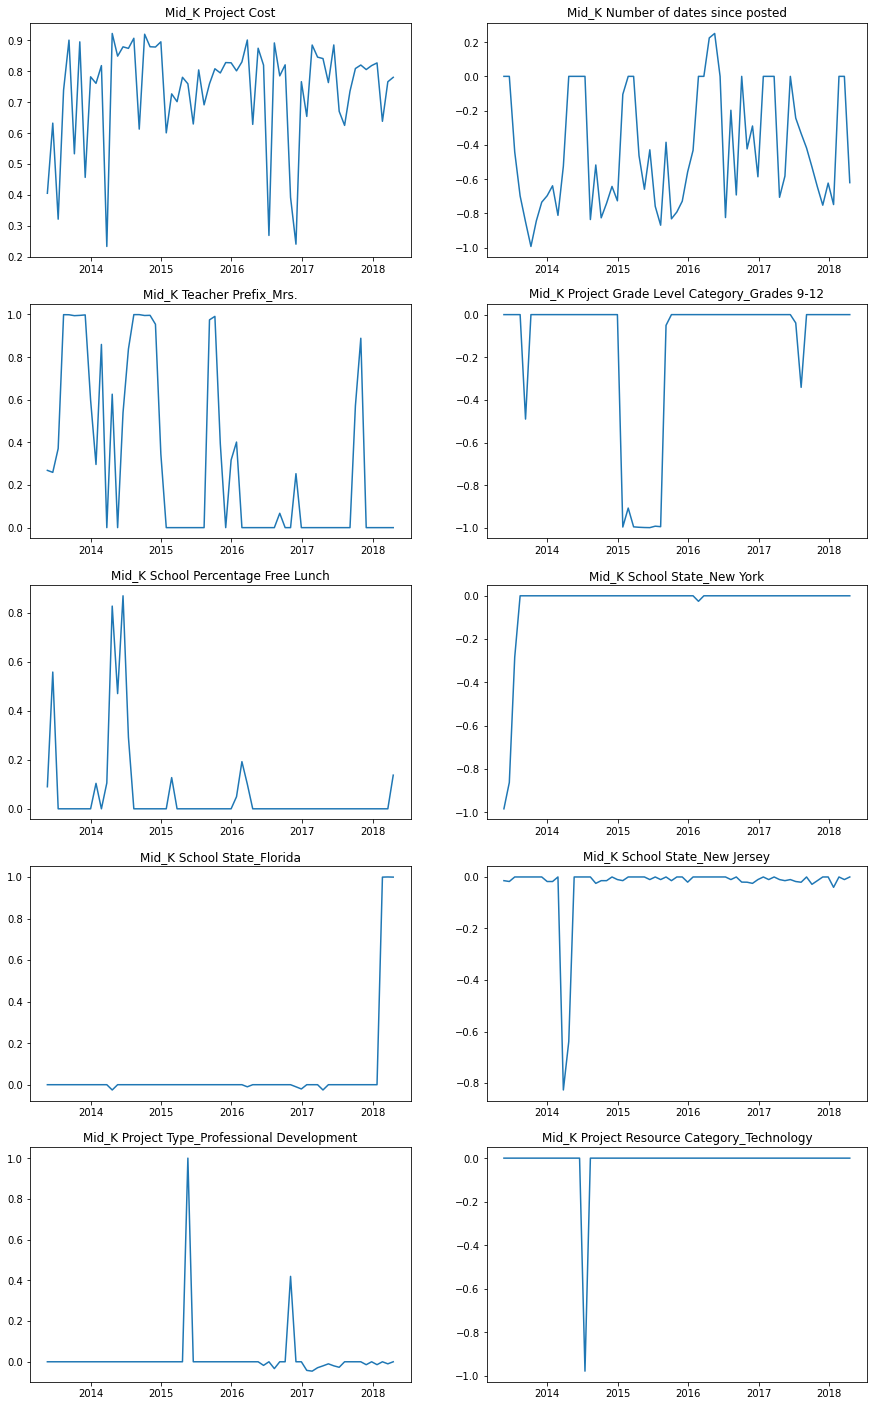

In [9]:
K=100
dict_top = dict()
top_ats=15
count=0
cols=[]
dates=[]
for date_index in range (3,len(Output['Time_points']),4):
#     print("===============================",Output['Time_points'][date_index],"=================================")
    As_of_top_K = Output["Explainer_df_Mid_K"][date_index].apply(pd.to_numeric, errors='ignore')
    As_of_top_K_np = As_of_top_K.to_numpy()
    As_of_top_K_np[As_of_top_K_np < 0] = 0
    As_of_top_K_pos_df = pd.DataFrame(data=As_of_top_K_np, columns=As_of_top_K.columns)  # 1st row as the column names
    Normalized_As_of_top_K_pos_df=(As_of_top_K_pos_df-As_of_top_K_pos_df.mean())/As_of_top_K_pos_df.std()
    important_columns_df = Normalized_As_of_top_K_pos_df.dropna(axis=1, how='all')
    
    Original_data = Output["Testing_data"][count]
    dates+=[Output['Time_points'][date_index]]
    dict_top[Output['Time_points'][date_index]]=dict()
    for col_name in important_columns_df.columns:
        if col_name not in cols: cols+=[col_name]
        start = int(len(Original_data[col_name])/2) 
        end = int(len(Original_data[col_name])/2) +100      
        co = np.corrcoef(Original_data[col_name].iloc[start:end],important_columns_df[col_name])[0,1]
        if pd.notna(co):
            dict_top[Output['Time_points'][date_index]][col_name]=co
    count+=1

df_Top = pd.DataFrame(columns=dates)
for col_name in cols:
    df_Top.loc[col_name] = 0.0
for d in dict_top:
    for c in dict_top[d]:
        df_Top.at[c, d] = dict_top[d][c]
df_Top_transposed = df_Top.T
describe_top_df = df_Top_transposed.describe().T
describe_top_df= describe_top_df.sort_values(by=['mean'], ascending=False)

fig, axs = plt.subplots(5, 2,figsize=(15,25))
        
for i in range (5):
    print(describe_top_df.index[i])
    axs[i, 0].plot(df_Top_transposed[describe_top_df.index[i]])
    axs[i, 0].title.set_text("Mid_K "+describe_top_df.index[i])

for i in range (1,6):
    print(describe_top_df.index[-i])
    axs[i-1, 1].plot(df_Top_transposed[describe_top_df.index[-i]])
    axs[i-1, 1].title.set_text("Mid_K "+describe_top_df.index[-i]) 
            


c:\users\redline pc\appdata\local\programs\python\python38\lib\site-packages\numpy\lib\function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
c:\users\redline pc\appdata\local\programs\python\python38\lib\site-packages\numpy\lib\function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
c:\users\redline pc\appdata\local\programs\python\python38\lib\site-packages\numpy\lib\function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
c:\users\redline pc\appdata\local\programs\python\python38\lib\site-packages\numpy\lib\function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
c:\users\redline pc\appdata\local\programs\python\python38\lib\site-packages\numpy\lib\function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
c:\users\redline pc\appdata\local\programs\python\

c:\users\redline pc\appdata\local\programs\python\python38\lib\site-packages\numpy\lib\function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
c:\users\redline pc\appdata\local\programs\python\python38\lib\site-packages\numpy\lib\function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
c:\users\redline pc\appdata\local\programs\python\python38\lib\site-packages\numpy\lib\function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
c:\users\redline pc\appdata\local\programs\python\python38\lib\site-packages\numpy\lib\function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
c:\users\redline pc\appdata\local\programs\python\python38\lib\site-packages\numpy\lib\function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
c:\users\redline pc\appdata\local\programs\python\

c:\users\redline pc\appdata\local\programs\python\python38\lib\site-packages\numpy\lib\function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
c:\users\redline pc\appdata\local\programs\python\python38\lib\site-packages\numpy\lib\function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
c:\users\redline pc\appdata\local\programs\python\python38\lib\site-packages\numpy\lib\function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
c:\users\redline pc\appdata\local\programs\python\python38\lib\site-packages\numpy\lib\function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
c:\users\redline pc\appdata\local\programs\python\python38\lib\site-packages\numpy\lib\function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
c:\users\redline pc\appdata\local\programs\python\

Project Cost
School Percentage Free Lunch
Teacher Prefix_Mrs.
School State_Florida
Project Type_Professional Development
Number of dates since posted
Project Grade Level Category_Grades 9-12
School State_New York
School State_Massachusetts
School State_Minnesota


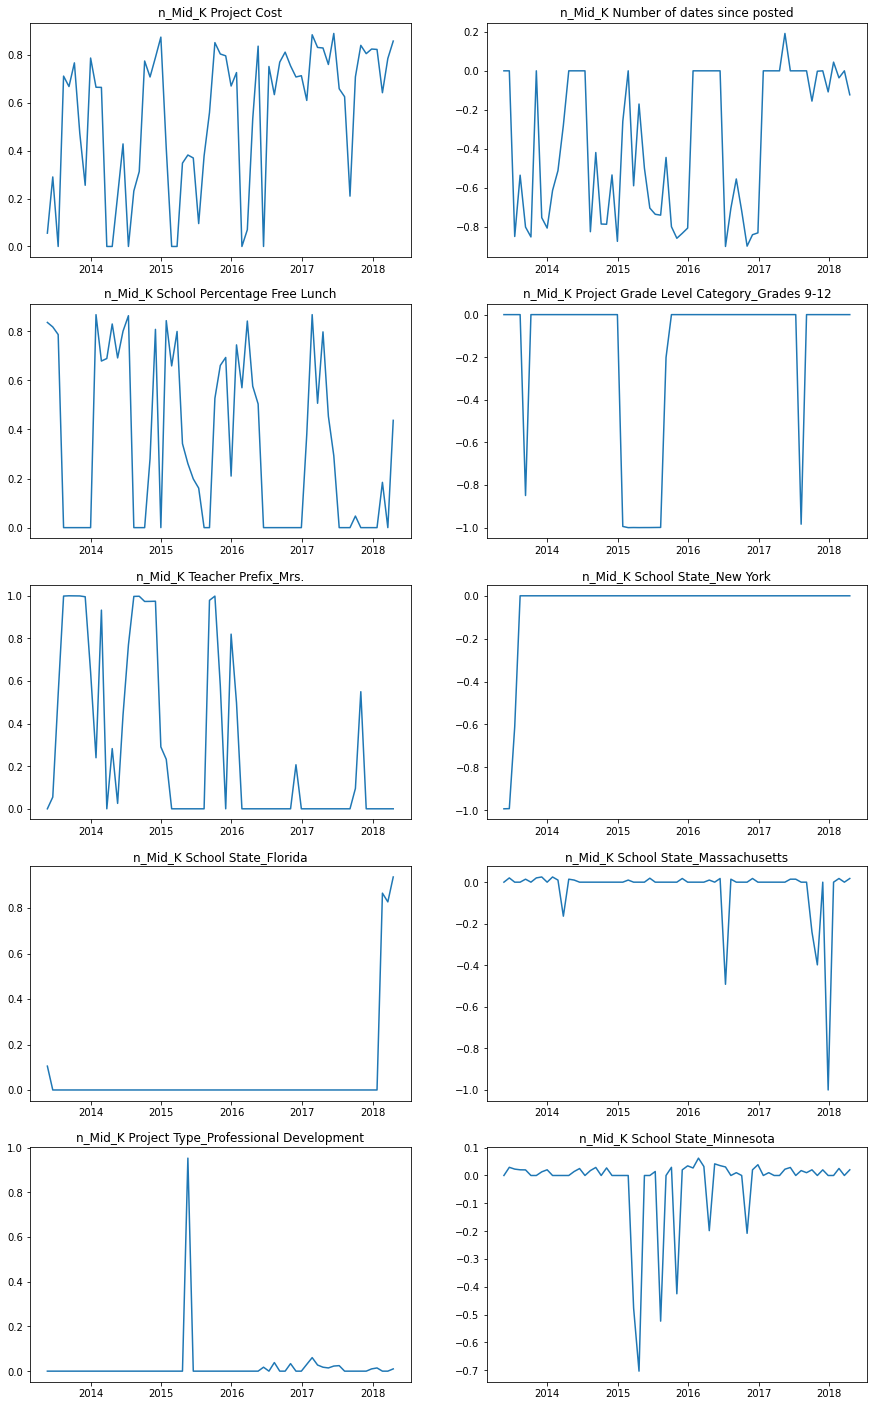

In [10]:
K=100
dict_top = dict()
top_ats=15
count=0
cols=[]
dates=[]
for date_index in range (3,len(Output['Time_points']),4):
#     print("===============================",Output['Time_points'][date_index],"=================================")
    As_of_top_K = Output["Explainer_df_Mid_K"][date_index].apply(pd.to_numeric, errors='ignore')
    As_of_top_K_np = As_of_top_K.to_numpy()
    As_of_top_K_np[As_of_top_K_np > 0] = 0
    As_of_top_K_pos_df = pd.DataFrame(data=As_of_top_K_np, columns=As_of_top_K.columns)  # 1st row as the column names
    Normalized_As_of_top_K_pos_df=(As_of_top_K_pos_df-As_of_top_K_pos_df.mean())/As_of_top_K_pos_df.std()
    important_columns_df = Normalized_As_of_top_K_pos_df.dropna(axis=1, how='all')
    
    Original_data = Output["Testing_data"][count]
    dates+=[Output['Time_points'][date_index]]
    dict_top[Output['Time_points'][date_index]]=dict()
    for col_name in important_columns_df.columns:
        if col_name not in cols: cols+=[col_name]
        start = int(len(Original_data[col_name])/2) 
        end = int(len(Original_data[col_name])/2) +100      
        co = np.corrcoef(Original_data[col_name].iloc[start:end],important_columns_df[col_name])[0,1]
        if pd.notna(co):
            dict_top[Output['Time_points'][date_index]][col_name]=co
    count+=1

df_Top = pd.DataFrame(columns=dates)
for col_name in cols:
    df_Top.loc[col_name] = 0.0
for d in dict_top:
    for c in dict_top[d]:
        df_Top.at[c, d] = dict_top[d][c]
df_Top_transposed = df_Top.T
describe_top_df = df_Top_transposed.describe().T
describe_top_df= describe_top_df.sort_values(by=['mean'], ascending=False)

fig, axs = plt.subplots(5, 2,figsize=(15,25))
        
for i in range (5):
    print(describe_top_df.index[i])
    axs[i, 0].plot(df_Top_transposed[describe_top_df.index[i]])
    axs[i, 0].title.set_text("n_Mid_K "+describe_top_df.index[i])

for i in range (1,6):
    print(describe_top_df.index[-i])
    axs[i-1, 1].plot(df_Top_transposed[describe_top_df.index[-i]])
    axs[i-1, 1].title.set_text("n_Mid_K "+describe_top_df.index[-i]) 
            


In [15]:
import shap
explainer = shap.TreeExplainer(Output["Classifier"])
shap_values = explainer.shap_values(Output["Testing_data"][3])

# visualize the first prediction's explanation
shap.force_plot(explainer.expected_value, Output["Testing_data"][3], Output["Testing_data"][3].iloc[0,:])

AssertionError: visualize() can only display Explanation objects (or arrays of them)!

In [ ]:
[Output["Explainer_df_Top_K"]]